Gaussian White Noise Restoration via CSC
========================================

This example demonstrates the removal of Gaussian white noise from a greyscale image using the CSC problem

  $$\mathrm{argmin}_\mathbf{x} \; (1/2) \sum_c \left\| \sum_m \mathbf{d}_{c,m} * \mathbf{x}_m -\mathbf{s}_c \right\|_2^2 + \lambda \sum_m \| \mathbf{x}_m \|_1 \;,$$

where $\mathbf{d}_m$ is the $m^{\text{th}}$ dictionary filter, $\mathbf{x}_m$ is the coefficient map corresponding to the $m^{\text{th}}$ dictionary filter, $\mathbf{s}$ is the input image.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import plot
plot.config_notebook_plotting()
import sporco.linalg as spl
import sporco.metric as sm
from sporco.admm import cbpdn

Boundary artifacts are handled by performing a symmetric extension on the image to be denoised and then cropping the result to the original image support. This approach is simpler than the boundary handling strategies that involve the insertion of a spatial mask into the data fidelity term, and for many problems gives results of comparable quality. The functions defined here implement symmetric extension and cropping of images.

In [2]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

Load a reference image and corrupt it with Gaussian white noise with $\sigma = 0.1$. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])
np.random.seed(12345)
imgn = img + np.random.normal(0.0, 0.1, img.shape)

Highpass filter test image.

In [4]:
npd = 16
fltlmbd = 5.0
imgnl, imgnh = util.tikhonov_filter(imgn, fltlmbd, npd)

Load dictionary.

In [5]:
D = util.convdicts()['G:8x8x128']

Set solver options. See Section 8 of [[34]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2017-convolutional2) for details of construction of $\ell_1$ weighting matrix $W$.

In [6]:
imgnpl, imgnph = util.tikhonov_filter(pad(imgn), fltlmbd, npd)
W = spl.irfftn(np.conj(spl.rfftn(D, imgnph.shape, (0, 1))) *
               spl.rfftn(imgnph[..., np.newaxis], None, (0, 1)),
               imgnph.shape, (0,1))
W = W**2
W = 1.0/(np.maximum(np.abs(W), 1e-8))

lmbda = 4.8e-2

opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 250,
            'HighMemSolve': True, 'RelStopTol': 3e-3, 'AuxVarObj': False,
            'L1Weight': W, 'AutoRho': {'Enabled': False}, 'rho': 4e2*lmbda})

Initialise the [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) object and call the ``solve`` method.

In [7]:
b = cbpdn.ConvBPDN(D, pad(imgnh), lmbda, opt, dimK=0)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s         
------------------------------------------------------


   0  2.12e+07  4.08e+01  4.42e+08  9.74e-01  1.30e-01


   1  9.17e+06  1.44e+02  1.91e+08  7.16e-01  2.28e-01


   2  5.53e+06  1.86e+02  1.15e+08  3.29e-01  2.00e-01


   3  4.65e+06  2.12e+02  9.69e+07  2.39e-01  1.19e-01


   4  3.68e+06  2.28e+02  7.67e+07  1.85e-01  1.07e-01


   5  3.18e+06  2.42e+02  6.63e+07  1.49e-01  9.18e-02


   6  2.82e+06  2.53e+02  5.87e+07  1.25e-01  6.84e-02


   7  2.58e+06  2.61e+02  5.37e+07  1.03e-01  5.46e-02


   8  2.36e+06  2.67e+02  4.92e+07  8.37e-02  4.93e-02


   9  2.18e+06  2.71e+02  4.54e+07  6.91e-02  4.52e-02


  10  2.01e+06  2.74e+02  4.19e+07  5.84e-02  4.02e-02


  11  1.84e+06  2.76e+02  3.84e+07  5.03e-02  3.53e-02


  12  1.68e+06  2.77e+02  3.50e+07  4.37e-02  3.17e-02


  13  1.54e+06  2.79e+02  3.21e+07  3.83e-02  2.89e-02


  14  1.41e+06  2.80e+02  2.94e+07  3.39e-02  2.64e-02


  15  1.30e+06  2.81e+02  2.71e+07  3.02e-02  2.41e-02


  16  1.20e+06  2.82e+02  2.51e+07  2.70e-02  2.21e-02


  17  1.11e+06  2.83e+02  2.31e+07  2.43e-02  2.05e-02


  18  1.02e+06  2.84e+02  2.13e+07  2.19e-02  1.92e-02


  19  9.48e+05  2.84e+02  1.97e+07  1.99e-02  1.81e-02


  20  8.77e+05  2.85e+02  1.83e+07  1.81e-02  1.70e-02


  21  8.12e+05  2.85e+02  1.69e+07  1.66e-02  1.60e-02


  22  7.52e+05  2.85e+02  1.57e+07  1.53e-02  1.51e-02


  23  6.97e+05  2.85e+02  1.45e+07  1.41e-02  1.43e-02


  24  6.48e+05  2.85e+02  1.35e+07  1.31e-02  1.36e-02


  25  6.04e+05  2.85e+02  1.26e+07  1.22e-02  1.30e-02


  26  5.64e+05  2.85e+02  1.17e+07  1.14e-02  1.24e-02


  27  5.27e+05  2.86e+02  1.10e+07  1.06e-02  1.18e-02


  28  4.93e+05  2.86e+02  1.03e+07  1.00e-02  1.13e-02


  29  4.62e+05  2.86e+02  9.62e+06  9.43e-03  1.08e-02


  30  4.32e+05  2.86e+02  9.00e+06  8.90e-03  1.04e-02


  31  4.04e+05  2.86e+02  8.41e+06  8.42e-03  1.00e-02


  32  3.78e+05  2.86e+02  7.88e+06  7.98e-03  9.64e-03


  33  3.54e+05  2.86e+02  7.38e+06  7.58e-03  9.28e-03


  34  3.32e+05  2.86e+02  6.92e+06  7.21e-03  8.96e-03


  35  3.12e+05  2.86e+02  6.49e+06  6.87e-03  8.67e-03


  36  2.93e+05  2.86e+02  6.10e+06  6.56e-03  8.38e-03


  37  2.76e+05  2.86e+02  5.74e+06  6.28e-03  8.13e-03


  38  2.59e+05  2.86e+02  5.40e+06  6.02e-03  7.89e-03


  39  2.44e+05  2.86e+02  5.09e+06  5.78e-03  7.66e-03


  40  2.30e+05  2.86e+02  4.79e+06  5.56e-03  7.45e-03


  41  2.17e+05  2.86e+02  4.52e+06  5.36e-03  7.25e-03


  42  2.05e+05  2.86e+02  4.26e+06  5.16e-03  7.06e-03


  43  1.93e+05  2.86e+02  4.02e+06  4.98e-03  6.88e-03


  44  1.82e+05  2.86e+02  3.80e+06  4.82e-03  6.71e-03


  45  1.73e+05  2.86e+02  3.59e+06  4.65e-03  6.55e-03


  46  1.63e+05  2.86e+02  3.39e+06  4.51e-03  6.38e-03


  47  1.55e+05  2.86e+02  3.22e+06  4.37e-03  6.24e-03


  48  1.47e+05  2.86e+02  3.05e+06  4.24e-03  6.10e-03


  49  1.39e+05  2.86e+02  2.89e+06  4.11e-03  5.96e-03


  50  1.32e+05  2.86e+02  2.75e+06  4.00e-03  5.83e-03


  51  1.26e+05  2.86e+02  2.61e+06  3.88e-03  5.71e-03


  52  1.20e+05  2.86e+02  2.49e+06  3.77e-03  5.57e-03


  53  1.14e+05  2.86e+02  2.37e+06  3.67e-03  5.45e-03


  54  1.09e+05  2.86e+02  2.26e+06  3.57e-03  5.33e-03


  55  1.04e+05  2.86e+02  2.16e+06  3.47e-03  5.22e-03


  56  9.93e+04  2.86e+02  2.06e+06  3.39e-03  5.11e-03


  57  9.51e+04  2.86e+02  1.98e+06  3.30e-03  5.01e-03


  58  9.11e+04  2.86e+02  1.89e+06  3.22e-03  4.92e-03


  59  8.75e+04  2.86e+02  1.82e+06  3.15e-03  4.83e-03


  60  8.40e+04  2.86e+02  1.75e+06  3.07e-03  4.74e-03


  61  8.10e+04  2.86e+02  1.68e+06  3.00e-03  4.65e-03


  62  7.80e+04  2.86e+02  1.62e+06  2.94e-03  4.56e-03


  63  7.52e+04  2.86e+02  1.56e+06  2.87e-03  4.48e-03


  64  7.24e+04  2.86e+02  1.50e+06  2.81e-03  4.40e-03


  65  6.98e+04  2.86e+02  1.45e+06  2.75e-03  4.32e-03


  66  6.73e+04  2.86e+02  1.40e+06  2.69e-03  4.25e-03


  67  6.49e+04  2.86e+02  1.35e+06  2.63e-03  4.17e-03


  68  6.29e+04  2.86e+02  1.30e+06  2.58e-03  4.09e-03


  69  6.08e+04  2.86e+02  1.26e+06  2.52e-03  4.02e-03


  70  5.88e+04  2.86e+02  1.22e+06  2.47e-03  3.95e-03


  71  5.69e+04  2.86e+02  1.18e+06  2.42e-03  3.89e-03


  72  5.49e+04  2.86e+02  1.14e+06  2.37e-03  3.83e-03


  73  5.32e+04  2.86e+02  1.10e+06  2.33e-03  3.77e-03


  74  5.14e+04  2.86e+02  1.07e+06  2.29e-03  3.70e-03


  75  4.98e+04  2.86e+02  1.03e+06  2.24e-03  3.64e-03


  76  4.83e+04  2.86e+02  9.99e+05  2.20e-03  3.59e-03


  77  4.69e+04  2.86e+02  9.71e+05  2.16e-03  3.54e-03


  78  4.55e+04  2.86e+02  9.42e+05  2.12e-03  3.48e-03


  79  4.42e+04  2.86e+02  9.15e+05  2.08e-03  3.43e-03


  80  4.29e+04  2.86e+02  8.88e+05  2.05e-03  3.38e-03


  81  4.17e+04  2.86e+02  8.63e+05  2.01e-03  3.33e-03


  82  4.05e+04  2.86e+02  8.38e+05  1.98e-03  3.28e-03


  83  3.95e+04  2.86e+02  8.16e+05  1.95e-03  3.24e-03


  84  3.84e+04  2.86e+02  7.95e+05  1.92e-03  3.20e-03


  85  3.74e+04  2.86e+02  7.74e+05  1.89e-03  3.16e-03


  86  3.65e+04  2.86e+02  7.54e+05  1.86e-03  3.11e-03


  87  3.56e+04  2.86e+02  7.35e+05  1.83e-03  3.07e-03


  88  3.48e+04  2.86e+02  7.18e+05  1.80e-03  3.03e-03


  89  3.39e+04  2.86e+02  7.00e+05  1.77e-03  2.99e-03
------------------------------------------------------


The denoised estimate of the image is just the reconstruction from the coefficient maps.

In [8]:
imgdp = b.reconstruct().squeeze()
imgd = np.clip(crop(imgdp) + imgnl, 0, 1)

Display solve time and denoising performance.

In [9]:
print("ConvBPDN solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % sm.psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % sm.psnr(img, imgd))

ConvBPDN solve time: 122.28 s
Noisy image PSNR:    19.21 dB
Denoised image PSNR: 26.25 dB


Display the reference, noisy, and denoised images.

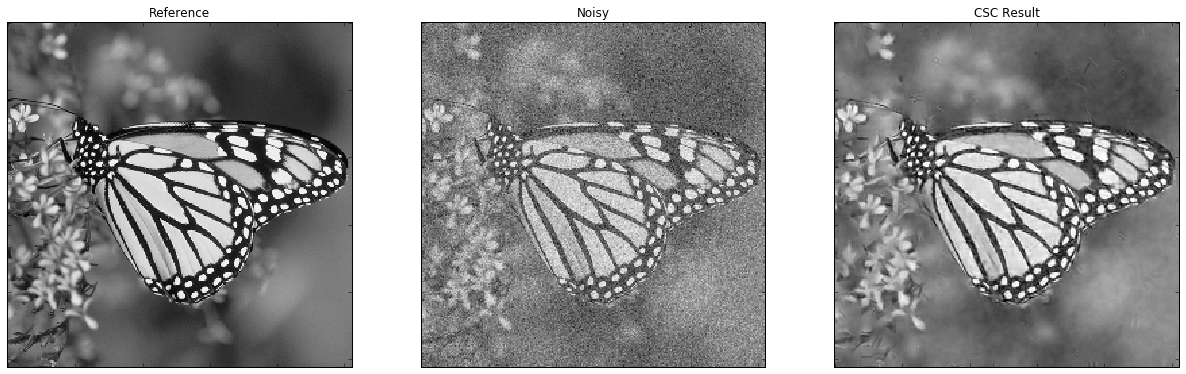

In [10]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgn, title='Noisy', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgd, title='CSC Result', fig=fig)
fig.show()

Plot functional evolution during ADMM iterations.

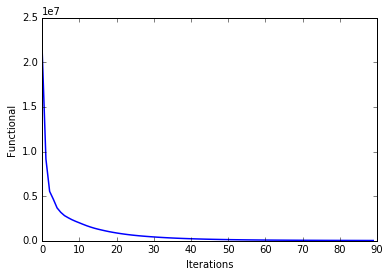

In [11]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')

Plot evolution of ADMM residuals and ADMM penalty parameter.

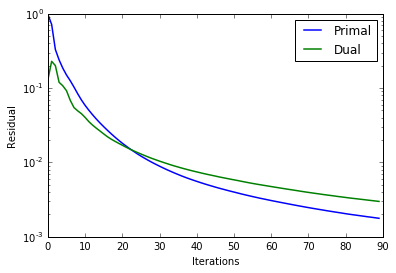

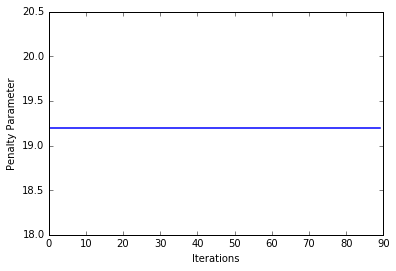

In [12]:
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'])
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter')